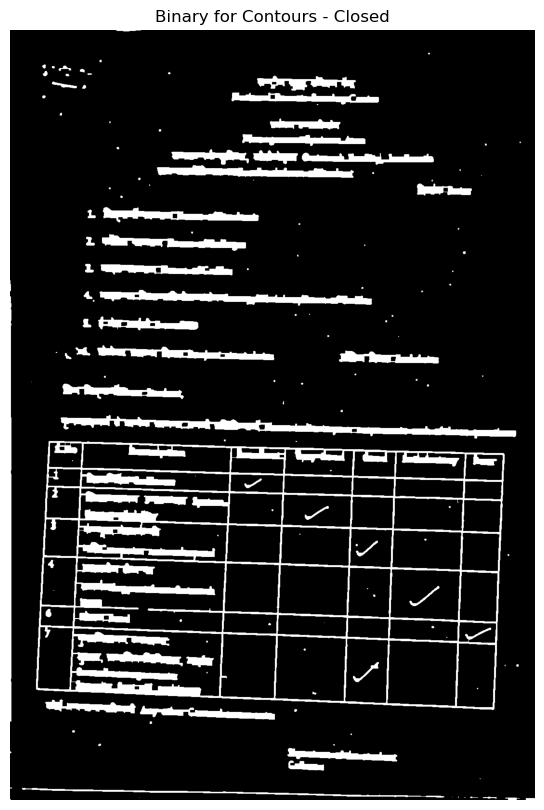

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def display_image(image, title="Image", cmap=None):
    plt.figure(figsize=(10, 10))
    if cmap:
        plt.imshow(image, cmap=cmap)
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

image_path = 'images/test2.jpg' # Make sure this path is correct
original_image = cv2.imread(image_path)
if original_image is None:
    print(f"Error: Could not load image at {image_path}")
    exit()

img_height, img_width = original_image.shape[:2]
gray = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
# display_image(gray, "Grayscale", cmap='gray')

# Blur to reduce noise and help contour detection
blurred = cv2.GaussianBlur(gray, (7, 7), 0)
# display_image(blurred, "Blurred", cmap='gray')

# Binarize: Adaptive thresholding is good for varying lighting/contrast
# We want table lines to be black on white for contour finding or white on black for line extraction
# For contour finding of the table boundary, let's try to get black lines on white background
binary_for_contours = cv2.adaptiveThreshold(
    blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV, 31, 20 # Block size, C value - TUNE THESE
)
# display_image(binary_for_contours, "Binary for Contours", cmap='gray')

# Optional: Morphological operations to close gaps in table borders if necessary
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,3))
binary_for_contours = cv2.morphologyEx(binary_for_contours, cv2.MORPH_CLOSE, kernel, iterations=2)
display_image(binary_for_contours, "Binary for Contours - Closed", cmap='gray')

Table ROI extracted at: x=55, y=855, w=970, h=556


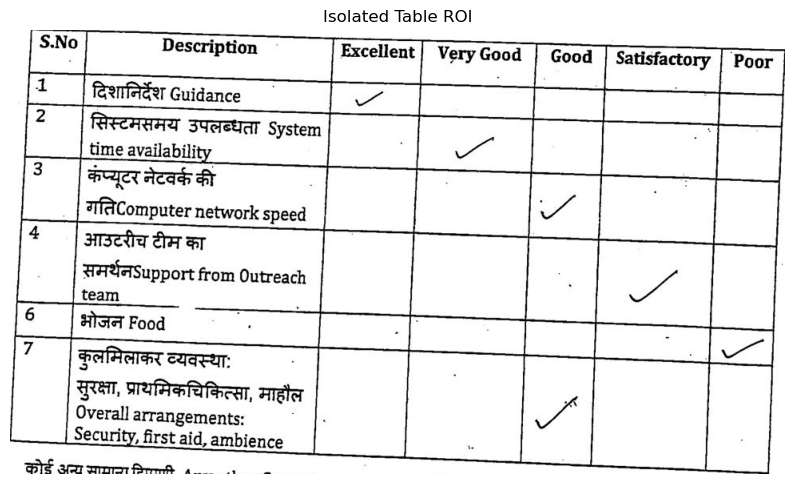

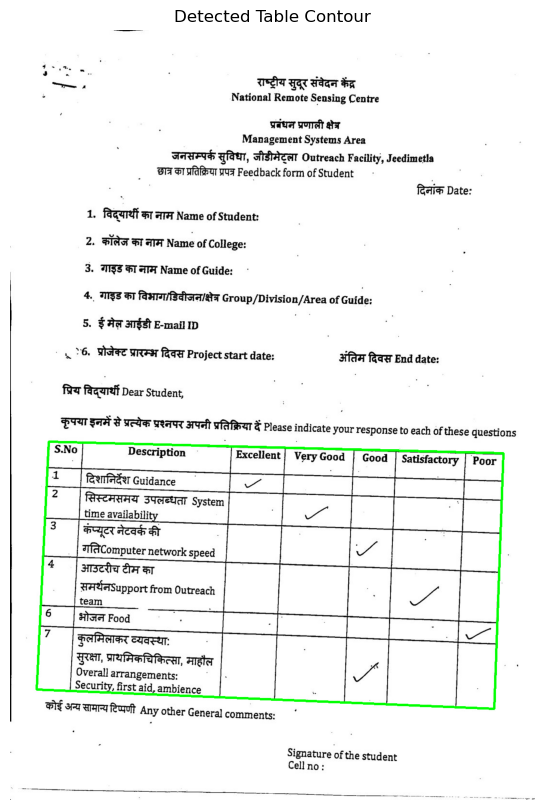

In [3]:
contours, hierarchy = cv2.findContours(binary_for_contours, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter contours to find the table
# Criteria: Area, Aspect Ratio, Number of vertices (should be ~4 for a rectangle)
possible_tables = []
for contour in contours:
    area = cv2.contourArea(contour)
    if area < (img_width * img_height * 0.05) or area > (img_width * img_height * 0.8): # Min/Max area
        continue

    peri = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.02 * peri, True) # 0.02 is a common factor

    if len(approx) == 4: # Should be a quadrilateral
        x, y, w, h = cv2.boundingRect(approx)
        aspect_ratio = w / float(h)
        # Add more specific aspect ratio constraints if needed
        # e.g. if aspect_ratio > 0.5 and aspect_ratio < 3:
        if w > img_width * 0.3 and h > img_height * 0.1: # Min width and height
            possible_tables.append({
                'contour': approx,
                'area': area,
                'bbox': (x, y, w, h)
            })

if not possible_tables:
    print("No potential table contours found. Try adjusting preprocessing or contour filtering.")
    # Fallback: use the whole image, or a manually defined region if necessary
    table_roi = original_image.copy()
    table_bbox = (0,0, img_width, img_height)
else:
    # Sort by area (largest first) or y-coordinate (to get lower tables)
    # For this image, the table is quite large and distinct.
    possible_tables = sorted(possible_tables, key=lambda x: x['area'], reverse=True)
    best_table_contour = possible_tables[0]['contour']
    table_bbox = possible_tables[0]['bbox']
    x, y, w, h = table_bbox

    # Crop the original image to get the Table ROI
    table_roi = original_image[y:y+h, x:x+w]
    print(f"Table ROI extracted at: x={x}, y={y}, w={w}, h={h}")
    display_image(table_roi, "Isolated Table ROI")

# --- Debug: Draw the detected table contour on the original image ---
debug_image_contours = original_image.copy()
if possible_tables:
     cv2.drawContours(debug_image_contours, [best_table_contour], -1, (0,255,0), 3)
display_image(debug_image_contours, "Detected Table Contour")

Table unwarped to: Width=950, Height=531


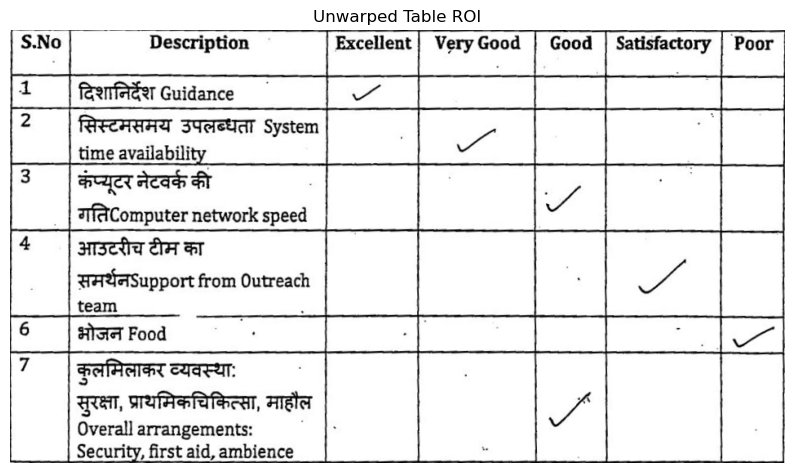

In [4]:
def order_points(pts):
    # pts is a NumPy array of shape (N, 2) representing N points
    # For a quadrilateral, N=4
    rect = np.zeros((4, 2), dtype="float32")

    # The top-left point will have the smallest sum (x+y),
    # the bottom-right point will have the largest sum.
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)] # Top-left
    rect[2] = pts[np.argmax(s)] # Bottom-right

    # Now, compute the difference between the points (y-x).
    # The top-right point will have the smallest difference,
    # the bottom-left will have the largest difference.
    diff = np.diff(pts, axis=1) # For (N,1,2) array from approxPolyDP, use pts.reshape(4,2) first
                                # If pts is already (4,2), then diff = pts[:,1] - pts[:,0]
    
    # Recalculate diff for (4,2) array
    # diff_y_minus_x = pts[:, 1] - pts[:, 0] # Not robust enough
    
    # Alternative for TR and BL using x-coordinates after TL and BR are found
    # Remaining points after removing TL and BR
    remaining_pts = np.array([p for p in pts if not np.all(p == rect[0]) and not np.all(p == rect[2])])

    # Top-right has smaller y (or larger x if y is same)
    # Bottom-left has larger y (or smaller x if y is same)
    if remaining_pts[0][1] < remaining_pts[1][1]: # if first remaining point y < second remaining point y
        rect[1] = remaining_pts[0] # Top-right
        rect[3] = remaining_pts[1] # Bottom-left
    elif remaining_pts[0][1] > remaining_pts[1][1]:
        rect[1] = remaining_pts[1] # Top-right
        rect[3] = remaining_pts[0] # Bottom-left
    else: # y-coordinates are the same, sort by x
        if remaining_pts[0][0] > remaining_pts[1][0]: # if first remaining point x > second remaining point x
            rect[1] = remaining_pts[0] # Top-right (larger x)
            rect[3] = remaining_pts[1] # Bottom-left (smaller x)
        else:
            rect[1] = remaining_pts[1] # Top-right
            rect[3] = remaining_pts[0] # Bottom-left
            
    return rect

# --- Inside your table detection logic ---
unwarped_table_roi = None
perspective_transform_matrix = None
inverse_perspective_transform_matrix = None
initial_table_roi_offset_x = 0 # Offset of the ROI in the original image if no unwarping
initial_table_roi_offset_y = 0

if possible_tables:
    # Assuming best_table_contour is already 'approx' from cv2.approxPolyDP
    # It should have shape (4, 1, 2). Reshape it to (4, 2)
    table_corners_skewed = best_table_contour.reshape(4, 2).astype("float32")

    # Order the points: tl, tr, br, bl
    src_pts = order_points(table_corners_skewed)
    (tl, tr, br, bl) = src_pts

    # Compute the width of the new unwarped image
    # (distance between tr and tl, or br and bl)
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # Compute the height of the new unwarped image
    # (distance between tr and br, or tl and bl)
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # Define destination points for the unwarped image (top-down view)
    dst_pts = np.array([
        [0, 0],                # Top-left
        [maxWidth - 1, 0],     # Top-right
        [maxWidth - 1, maxHeight - 1], # Bottom-right
        [0, maxHeight - 1]],   # Bottom-left
        dtype="float32")

    # Compute the perspective transform matrix
    perspective_transform_matrix = cv2.getPerspectiveTransform(src_pts, dst_pts)
    # Compute the inverse matrix for mapping points back to original image
    inverse_perspective_transform_matrix = cv2.getPerspectiveTransform(dst_pts, src_pts)


    # Apply the perspective warp
    unwarped_table_roi = cv2.warpPerspective(original_image, perspective_transform_matrix, (maxWidth, maxHeight))
    
    print(f"Table unwarped to: Width={maxWidth}, Height={maxHeight}")
    display_image(unwarped_table_roi, "Unwarped Table ROI")

    # This unwarped_table_roi will be used for cell detection
    table_roi_for_processing = unwarped_table_roi
    # The bounding box of this unwarped ROI (in its own coord system) is (0,0,maxWidth,maxHeight)
    # We don't need initial_table_roi_offset_x/y if unwarping is successful.

else:
    # Fallback: No table contour found, or decided not to unwarp
    print("No table contour found for unwarping, or unwarping skipped. Using direct crop or full image.")
    # Use the bounding box of the largest contour if available, or full image
    if possible_tables: # Should not happen if best_table_contour was None
         x_crop, y_crop, w_crop, h_crop = table_bbox # from previous step
         initial_table_roi_offset_x = x_crop
         initial_table_roi_offset_y = y_crop
         table_roi_for_processing = original_image[y_crop:y_crop+h_crop, x_crop:x_crop+w_crop]
    else:
         initial_table_roi_offset_x = 0
         initial_table_roi_offset_y = 0
         table_roi_for_processing = original_image.copy() # Process the whole image

In [5]:
if table_roi is None or table_roi.size == 0:
    print("Table ROI is empty, cannot proceed.")
    exit()

gray_table = cv2.cvtColor(table_roi_for_processing, cv2.COLOR_BGR2GRAY)
# display_image(gray_table, "Grayscale Table ROI", cmap='gray')

# Binarize for line detection: Lines should be white on black
# Adaptive thresholding is usually good
binary_table_lines = cv2.adaptiveThreshold(
    gray_table, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV, 11, 7 # Block size, C value - TUNE
)
# display_image(binary_table_lines, "Binary Table ROI for Lines", cmap='gray')

# --- Morphological operations to enhance lines (as in Option 2A detailed explanation) ---
roi_height, roi_width = binary_table_lines.shape[:2]

# Horizontal lines
h_kernel_len = max(10, roi_width // 30)
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (h_kernel_len, 1))
img_temp_h = cv2.erode(binary_table_lines, horizontal_kernel, iterations=1)
horizontal_lines_img = cv2.dilate(img_temp_h, horizontal_kernel, iterations=1)
# display_image(horizontal_lines_img, "Enhanced Horizontal Lines", cmap='gray')


# Vertical lines
v_kernel_len = max(10, roi_height // 30)
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, v_kernel_len))
img_temp_v = cv2.erode(binary_table_lines, vertical_kernel, iterations=1)
vertical_lines_img = cv2.dilate(img_temp_v, vertical_kernel, iterations=1)
# display_image(vertical_lines_img, "Enhanced Vertical Lines", cmap='gray')

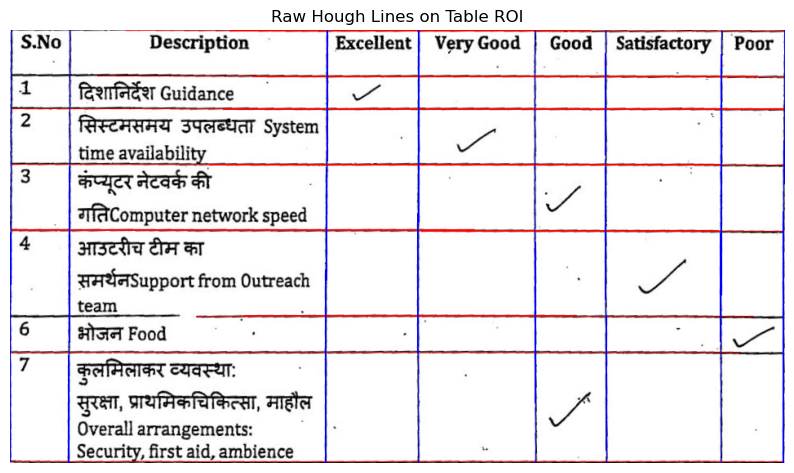

[np.int32(97), np.int32(395), np.int32(351), np.int32(529), np.int32(246), np.int32(57), np.int32(165), np.int32(1), np.int32(2), np.int32(98), np.int32(166), np.int32(58), np.int32(350), np.int32(247), np.int32(245)] [np.int32(730), np.int32(644), np.int32(500), np.int32(72), np.int32(871), np.int32(948), np.int32(643), np.int32(872), np.int32(387), np.int32(501), np.int32(947), np.int32(1), np.int32(73), np.int32(0), np.int32(388), np.int32(731), np.int32(729), np.int32(949), np.int32(386), np.int32(499), np.int32(870), np.int32(389), np.int32(71), np.int32(729)]


In [6]:
rho = 1
theta = np.pi / 180

# Adjust these thresholds and line parameters carefully for the table_roi
# minLineLength should be a significant fraction of the ROI's width/height
h_threshold = max(10, int(roi_width * 0.25)) # Require more votes for longer lines
h_min_line_length = max(30, int(roi_width * 0.4)) # Line must be reasonably long
h_max_line_gap = 10 # Allow some gap

v_threshold = max(10, roi_height // 10)
v_min_line_length = max(15, roi_height // 5)
v_max_line_gap = 10

h_lines = cv2.HoughLinesP(horizontal_lines_img, rho, theta, h_threshold,
                          minLineLength=h_min_line_length, maxLineGap=h_max_line_gap)

v_lines = cv2.HoughLinesP(vertical_lines_img, rho, theta, v_threshold,
                          minLineLength=v_min_line_length, maxLineGap=v_max_line_gap)

# --- Debug: Draw detected raw lines ---
table_roi_lines_drawn = table_roi_for_processing.copy()

raw_horizontal_y = []
if h_lines is not None:
    for line in h_lines:
        x1, y1, x2, y2 = line[0]
        raw_horizontal_y.append(y1)
        cv2.line(table_roi_lines_drawn,(x1,y1),(x2,y2),(0,0,255),1) # Blue for H

raw_vertical_x = []
if v_lines is not None:
    for line in v_lines:
        x1, y1, x2, y2 = line[0]
        raw_vertical_x.append(x1)
        cv2.line(table_roi_lines_drawn,(x1,y1),(x2,y2),(255,0,0),1) # Red for V
display_image(table_roi_lines_drawn, "Raw Hough Lines on Table ROI")
print(raw_horizontal_y, raw_vertical_x)

Final Horizontal y-coords: [np.int32(1), np.int32(57), np.int32(97), np.int32(165), np.int32(245), np.int32(350), np.int32(395), np.int32(529)]
Final Vertical x-coords: [np.int32(0), np.int32(71), np.int32(386), np.int32(499), np.int32(643), np.int32(729), np.int32(870), np.int32(947)]


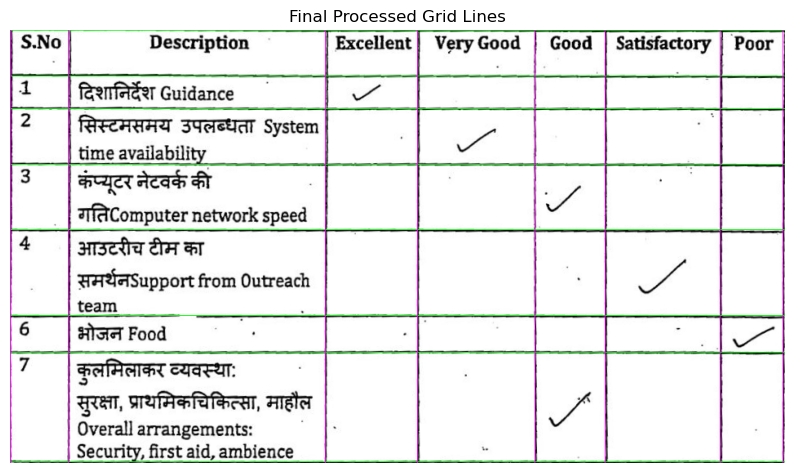

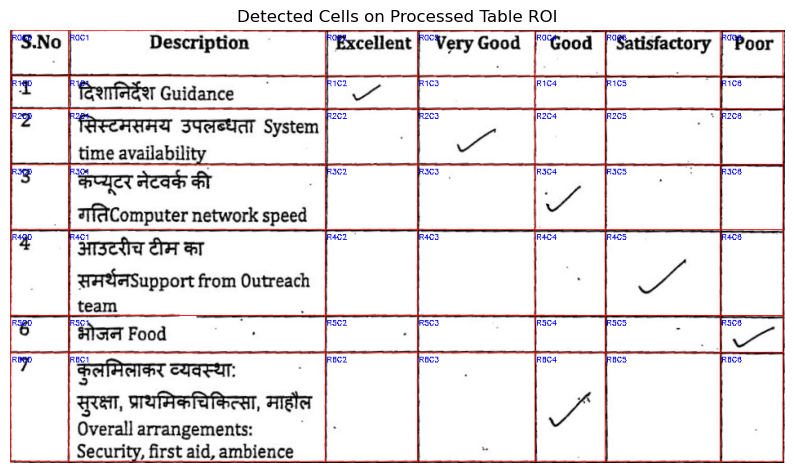

Extracted 49 cells.


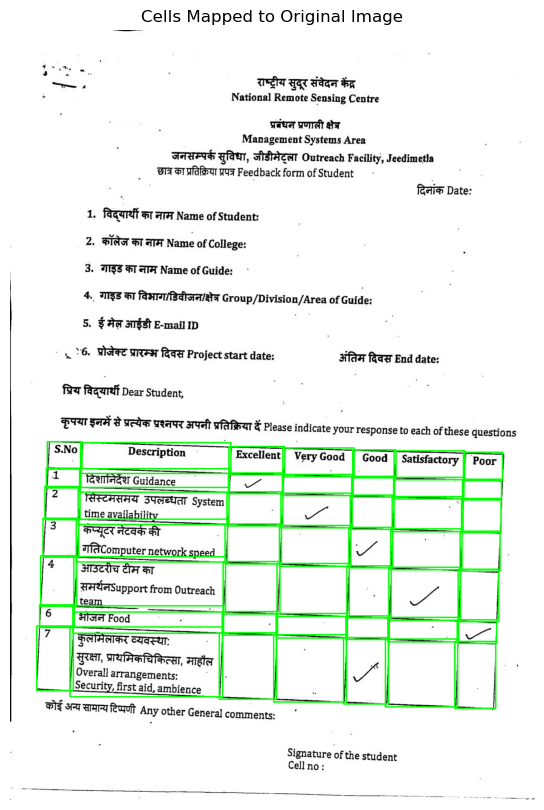

In [7]:
# (Include the average_lines and remove_close_coords functions here)
# def average_lines(lines, orientation='horizontal', tolerance=10, img_dim_for_extent=0):
#     if lines is None or len(lines) == 0:
#         return []
#     avg_lines_coords = []

#     if orientation == 'horizontal':
#         lines = sorted(lines, key=lambda line: line[0][1]) # Sort by y1
#         while lines:
#             current_group = [lines.pop(0)]
#             y_sum = current_group[0][0][1] + current_group[0][0][3] # y1+y2
#             x_coords = [current_group[0][0][0], current_group[0][0][2]]

#             i = 0
#             while i < len(lines):
#                 if abs(lines[i][0][1] - current_group[0][0][1]) < tolerance:
#                     grouped_line = lines.pop(i)
#                     y_sum += grouped_line[0][1] + grouped_line[0][3]
#                     x_coords.extend([grouped_line[0][0], grouped_line[0][2]])
#                 else:
#                     i += 1
            
#             avg_y = int(y_sum / (len(current_group) * 2))
#             min_x = min(x_coords) if x_coords else 0
#             max_x = max(x_coords) if x_coords else img_dim_for_extent # Use ROI width
#             avg_lines_coords.append([min_x, avg_y, max_x, avg_y])
            
#     else: # Vertical
#         lines = sorted(lines, key=lambda line: line[0][0]) # Sort by x1
#         while lines:
#             current_group = [lines.pop(0)]
#             x_sum = current_group[0][0][0] + current_group[0][0][2] # x1+x2
#             y_coords = [current_group[0][0][1], current_group[0][0][3]]

#             i = 0
#             while i < len(lines):
#                 if abs(lines[i][0][0] - current_group[0][0][0]) < tolerance:
#                     grouped_line = lines.pop(i)
#                     x_sum += grouped_line[0][0] + grouped_line[0][2]
#                     y_coords.extend([grouped_line[0][1], grouped_line[0][3]])
#                 else:
#                     i += 1
            
#             avg_x = int(x_sum / (len(current_group) * 2))
#             min_y = min(y_coords) if y_coords else 0
#             max_y = max(y_coords) if y_coords else img_dim_for_extent # Use ROI height
#             avg_lines_coords.append([avg_x, min_y, avg_x, max_y])
            
#     return [[line] for line in avg_lines_coords] # Keep format consistent with HoughLinesP output

def remove_close_coords(coords, min_dist=5): # Reduced min_dist for cells
    if not coords: return []
    unique_coords = [coords[0]]
    for i in range(1, len(coords)):
        if abs(coords[i] - unique_coords[-1]) >= min_dist:
            unique_coords.append(coords[i])
    return unique_coords



# --- Debug: Draw refined lines ---
# table_roi_refined_lines = table_roi_for_processing.copy()
# for line_group in [refined_h_lines, refined_v_lines]:
#     if line_group:
#         for line_entry in line_group:
#             line = line_entry[0] # line is wrapped in an extra list by average_lines
#             x1, y1, x2, y2 = line
#             color = (0, 255, 0) if abs(y1-y2) < abs(x1-x2) else (0,0,255) # Green H, Red V
#             cv2.line(table_roi_refined_lines, (x1, y1), (x2, y2), color, 2)
# display_image(table_roi_refined_lines, "Refined Lines on Table ROI")

min_line_dist_horizontal = 22
min_line_dist_vertical = 15

horizontal_y_coords = []
if raw_horizontal_y:
    horizontal_y_coords = remove_close_coords(sorted(list(set(raw_horizontal_y))), min_dist=min_line_dist_horizontal)

vertical_x_coords = []
if raw_vertical_x:
    vertical_x_coords = remove_close_coords(sorted(list(set(raw_vertical_x))), min_dist=min_line_dist_vertical)

# Add ROI boundaries if necessary (relative to table_roi)
# min_line_dist = 5 # TUNE: Minimum distance between lines to be considered separate
boundary_add_thresh_y = min_line_dist_horizontal * 0.8
boundary_add_thresh_x = min_line_dist_vertical * 0.8

if not horizontal_y_coords or (horizontal_y_coords and horizontal_y_coords[0] > boundary_add_thresh_y):
    horizontal_y_coords.insert(0, 0)
if not horizontal_y_coords or (horizontal_y_coords and horizontal_y_coords[-1] < roi_height - boundary_add_thresh_y):
    horizontal_y_coords.append(roi_height -1)
# Crucially, re-apply remove_close_coords after adding boundaries, in case a detected line was at the boundary
if horizontal_y_coords:
    horizontal_y_coords = remove_close_coords(sorted(list(set(horizontal_y_coords))), min_dist=min_line_dist_horizontal)

if not vertical_x_coords or (vertical_x_coords and vertical_x_coords[0] > boundary_add_thresh_x):
    vertical_x_coords.insert(0, 0)
if not vertical_x_coords or (vertical_x_coords and vertical_x_coords[-1] < roi_width - boundary_add_thresh_x):
    vertical_x_coords.append(roi_width -1)
if vertical_x_coords:
    vertical_x_coords = remove_close_coords(sorted(list(set(vertical_x_coords))), min_dist=min_line_dist_vertical)

print("Final Horizontal y-coords:", horizontal_y_coords)
print("Final Vertical x-coords:", vertical_x_coords)

# --- DEBUG VISUALIZATION: Draw these final lines ---
debug_final_lines_img = table_roi_for_processing.copy()
if len(debug_final_lines_img.shape) == 2: # If grayscale
    debug_final_lines_img = cv2.cvtColor(debug_final_lines_img, cv2.COLOR_GRAY2BGR)

for y_coord in horizontal_y_coords:
    cv2.line(debug_final_lines_img, (0, y_coord), (roi_width, y_coord), (0, 255, 0), 1) # Green horizontal
for x_coord in vertical_x_coords:
    cv2.line(debug_final_lines_img, (x_coord, 0), (x_coord, roi_height), (255, 0, 255), 1) # Magenta vertical

display_image(debug_final_lines_img, "Final Processed Grid Lines")

# --- Define and Extract Cells ---
cells_data = [] # To store cell image and its original coordinates
min_cell_height = 25 # TUNE
min_cell_width = 20  # TUNE

if len(table_roi_for_processing.shape) == 2 or table_roi_for_processing.shape[2] == 1:
    table_roi_with_cells_visualization = cv2.cvtColor(table_roi_for_processing, cv2.COLOR_GRAY2BGR)
else:
    table_roi_with_cells_visualization = table_roi_for_processing.copy() # For drawing

if len(horizontal_y_coords) >= 2 and len(vertical_x_coords) >= 2:
    for r_idx in range(len(horizontal_y_coords) - 1):
        y1_cell, y2_cell = horizontal_y_coords[r_idx], horizontal_y_coords[r_idx+1]
        if (y2_cell - y1_cell) < min_cell_height: continue

        for c_idx in range(len(vertical_x_coords) - 1):
            x1_cell, x2_cell = vertical_x_coords[c_idx], vertical_x_coords[c_idx+1]
            if (x2_cell - x1_cell) < min_cell_width: continue

            # Cell ROI extracted from gray_table (which is from table_roi_for_processing)
            cell_roi_image = gray_table[y1_cell:y2_cell, x1_cell:x2_cell]
            
             # --- MODIFICATION FOR CALCULATING ORIGINAL IMAGE COORDINATES ---
            bbox_in_original_image_tuple = None # Initialize (x, y, w, h)

            if inverse_perspective_transform_matrix is not None:
                # CASE 1: Unwarping was performed. Use inverse perspective transform.
                # Define the 4 corners of the cell in the unwarped image space
                cell_corners_in_roi_list = [
                    [x1_cell, y1_cell], [x2_cell, y1_cell],
                    [x2_cell, y2_cell], [x1_cell, y2_cell]
                ]
                cell_corners_in_roi_np = np.array([cell_corners_in_roi_list], dtype="float32")
                
                # Transform these corners back to the original image's coordinate system
                cell_corners_original_np = cv2.perspectiveTransform(cell_corners_in_roi_np, inverse_perspective_transform_matrix)
                
                # Get the axis-aligned bounding box of the transformed (potentially non-rectangular) quadrilateral
                orig_poly_points = cell_corners_original_np[0].astype(np.int32) # cv2.boundingRect needs int points
                bbox_orig_x, bbox_orig_y, bbox_orig_w, bbox_orig_h = cv2.boundingRect(orig_poly_points)
                bbox_in_original_image_tuple = (bbox_orig_x, bbox_orig_y, bbox_orig_w, bbox_orig_h)
            else:
                # CASE 2: No unwarping. table_roi_for_processing was a direct crop or the full image.
                # initial_table_roi_offset_x and _y are the top-left of this crop in the original image.
                # If table_roi_for_processing was the full original image, offsets are (0,0).
                
                orig_x_abs = initial_table_roi_offset_x + x1_cell
                orig_y_abs = initial_table_roi_offset_y + y1_cell
                cell_w_abs = x2_cell - x1_cell # Width of cell is preserved
                cell_h_abs = y2_cell - y1_cell # Height of cell is preserved
                bbox_in_original_image_tuple = (orig_x_abs, orig_y_abs, cell_w_abs, cell_h_abs)
            # --- END OF MODIFICATION ---

            cells_data.append({
                "image_roi": cell_roi_image,
                "row": r_idx,
                "col": c_idx,
                "bbox_in_table_roi": (x1_cell, y1_cell, x2_cell-x1_cell, y2_cell-y1_cell),
                "bbox_in_original_image": bbox_in_original_image_tuple # Store the correctly calculated tuple
            })
            
            # Draw on table_roi_with_cells_visualization (using local cell coordinates)
            cv2.rectangle(table_roi_with_cells_visualization, (x1_cell, y1_cell), (x2_cell, y2_cell), (0,0,255),1)
            label = f"R{r_idx}C{c_idx}"
            cv2.putText(table_roi_with_cells_visualization, label, (x1_cell + 2, y1_cell + 12),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 1) # Blue text
else:
    print("Not enough lines to form cells.")

display_image(table_roi_with_cells_visualization, "Detected Cells on Processed Table ROI")
print(f"Extracted {len(cells_data)} cells.")

# --- Example: To visualize these cells on the *original* full image ---
original_image_copy_for_final_viz = original_image.copy()
for cell_info in cells_data:
    if cell_info["bbox_in_original_image"]: # Check if it was successfully calculated
        x, y, w, h = cell_info["bbox_in_original_image"]
        cv2.rectangle(original_image_copy_for_final_viz, (x, y), (x + w, y + h), (0, 255, 0), 2) # Green box

display_image(original_image_copy_for_final_viz, "Cells Mapped to Original Image")


--- Detected Ticked Cells (Component Analysis) ---
TICK in Row: 0, Col: 2 (Header: Excellent), Component Area: 252
TICK in Row: 0, Col: 3 (Header: Very Good), Component Area: 122
TICK in Row: 0, Col: 4 (Header: Good), Component Area: 131
TICK in Row: 0, Col: 5 (Header: Satisfactory), Component Area: 215
TICK in Row: 0, Col: 6 (Header: Poor), Component Area: 175
TICK in Row: 1, Col: 2 (Header: Excellent), Component Area: 128
TICK in Row: 2, Col: 3 (Header: Very Good), Component Area: 193
TICK in Row: 2, Col: 6 (Header: Poor), Component Area: 177
TICK in Row: 3, Col: 4 (Header: Good), Component Area: 185
TICK in Row: 3, Col: 6 (Header: Poor), Component Area: 188
TICK in Row: 4, Col: 2 (Header: Excellent), Component Area: 178
TICK in Row: 4, Col: 5 (Header: Satisfactory), Component Area: 347
TICK in Row: 4, Col: 6 (Header: Poor), Component Area: 304
TICK in Row: 5, Col: 6 (Header: Poor), Component Area: 198
TICK in Row: 6, Col: 4 (Header: Good), Component Area: 277
TICK in Row: 6, Col: 6

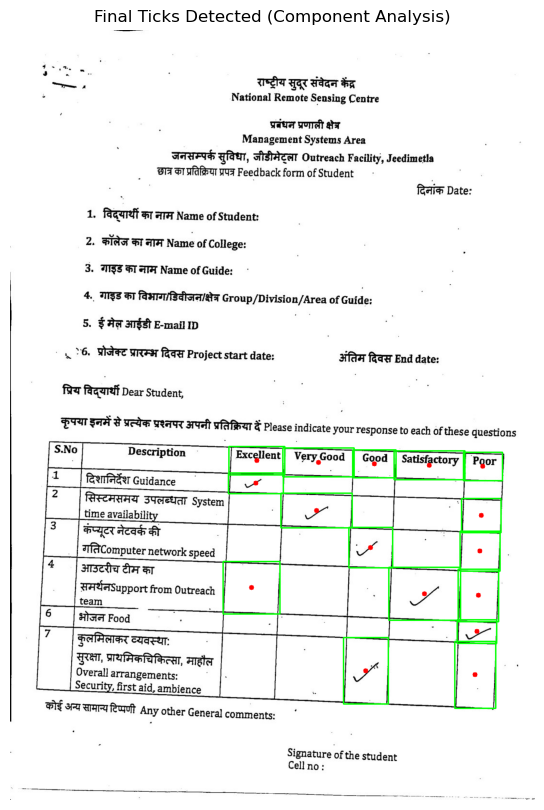

In [8]:
# Assuming 'cells_data' is populated correctly
# Assuming 'original_image' is your full BGR image for visualization
# Assuming 'display_image' function exists or you use cv2.imshow directly

ticked_cells_final = []
tick_columns_indices = [2, 3, 4, 5, 6]

original_image_column_headers = {
    "S.No": 0, "Description": 1, "Excellent": 2, "Very Good": 3,
    "Good": 4, "Satisfactory": 5, "Poor": 6
}
# Safer way to get column name from index
idx_to_col_name_map = {v: k for k, v in original_image_column_headers.items()}


# Parameters for binarization and initial pixel ratio (can be used as a pre-filter)
# pixel_ratio_min_prefilter = 0.01  # Optional: very loose pre-filter
# pixel_ratio_max_prefilter = 0.30  # Optional: very loose pre-filter
cell_padding_for_tick_detection = 2
# otsu_threshold_offset = -10 # Not used if relying purely on Otsu

# Parameters for connected components
min_tick_area = 100       # TUNE: Minimum pixel area for a component
max_tick_area_ratio = 0.07# TUNE: Max ratio of component area to core_cell_binary area (to avoid large text blobs)
min_aspect_ratio = 0.5    # TUNE: e.g., for a typical checkmark ✓
max_aspect_ratio = 1.5    # TUNE

quit_debug_view = False # Flag to break out of all imshow loops

for cell_info in cells_data:
    if quit_debug_view:
        break
    if cell_info['col'] not in tick_columns_indices:
        continue

    cell_img_roi = cell_info['image_roi']
    if cell_img_roi is None or cell_img_roi.size == 0:
        continue

    blurred_cell = cv2.GaussianBlur(cell_img_roi, (3,3), 0)
    otsu_thresh_val, binary_tick_cell = cv2.threshold(
        blurred_cell, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
    )

    h, w = binary_tick_cell.shape
    if h > 2 * cell_padding_for_tick_detection and w > 2 * cell_padding_for_tick_detection:
        core_cell_binary = binary_tick_cell[
            cell_padding_for_tick_detection : h - cell_padding_for_tick_detection,
            cell_padding_for_tick_detection : w - cell_padding_for_tick_detection,
        ]
    else:
        core_cell_binary = binary_tick_cell

    if core_cell_binary.size == 0:
        continue
        
    # --- This variable is needed for max_tick_area_ratio ---
    total_pixels_in_core = core_cell_binary.shape[0] * core_cell_binary.shape[1]
    if total_pixels_in_core == 0: # Should not happen if core_cell_binary.size > 0 but good check
        continue

    # --- Connected Components Analysis ---
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(core_cell_binary, connectivity=8)
    found_tick_component = False
    tick_component_area = 0 # Store area of the component identified as a tick

    valid_components_in_cell = 0
    if num_labels > 1:
        for i in range(1, num_labels):
            comp_x = stats[i, cv2.CC_STAT_LEFT]
            comp_y = stats[i, cv2.CC_STAT_TOP]
            comp_w = stats[i, cv2.CC_STAT_WIDTH]
            comp_h = stats[i, cv2.CC_STAT_HEIGHT]
            comp_area = stats[i, cv2.CC_STAT_AREA]

            if comp_area < min_tick_area:
                continue
            
            # Check component area against total_pixels_in_core
            if total_pixels_in_core > 0 and (comp_area / total_pixels_in_core > max_tick_area_ratio):
                continue
        
            current_aspect_ratio = comp_w / float(comp_h) if comp_h > 0 else float('inf') # Avoid div by zero
            # Check if aspect ratio is within bounds (either w/h or h/w)
            is_aspect_ratio_ok = False
            if min_aspect_ratio < current_aspect_ratio < max_aspect_ratio:
                is_aspect_ratio_ok = True
                valid_components_in_cell += 1
            elif comp_w > 0 and (min_aspect_ratio < (comp_h / float(comp_w)) < max_aspect_ratio) : # Check inverse
                is_aspect_ratio_ok = True
                valid_components_in_cell += 1
                
            
            if not is_aspect_ratio_ok:
                # Alternative simpler check (less precise but might be okay):
                # if comp_w > comp_h * max_aspect_ratio or comp_h > comp_w * max_aspect_ratio:
                #    continue
                continue

            if valid_components_in_cell == 1:
                found_tick_component = True
                tick_component_area = comp_area # Store the area of the component that qualified
                break
            else:
                found_tick_component = False

    if found_tick_component:
        col_idx = cell_info['col']
        col_name = idx_to_col_name_map.get(col_idx, f"Unknown Col ({col_idx})")

        ticked_cells_final.append({
            "row": cell_info['row'],
            "col": col_idx,
            "col_name": col_name,
            "component_area": tick_component_area, # Store component area instead of potentially irrelevant pixel_ratio
            "original_bbox": cell_info['bbox_in_original_image']
        })
        
        # print(f"TICK Found (Component Analysis) in R{cell_info['row']}C{col_idx} ({col_name}), Area: {tick_component_area}, Otsu: {otsu_thresh_val}")
        # cv2.imshow(f"Cell R{cell_info['row']}C{col_idx} - Grayscale", cell_img_roi)
        # cv2.imshow(f"Cell R{cell_info['row']}C{col_idx} - Core Binary", core_cell_binary)
        # key = cv2.waitKey(0) & 0xFF
        # if key == ord('q'):
        #    quit_debug_view = True # Set flag to break outer loop too
        #    break # Break inner component loop
    # else: # Debugging for cells NOT flagged as ticks in target columns
        # if cell_info['row'] == 0 and cell_info['col'] == 2: # Example
        #    print(f"NO Tick (Component Analysis) in R{cell_info['row']}C{cell_info['col']}, Otsu: {otsu_thresh_val}")
        #    cv2.imshow(f"NO Tick Cell R{cell_info['row']}C{cell_info['col']} - Grayscale", cell_img_roi)
        #    cv2.imshow(f"NO Tick Cell R{cell_info['row']}C{cell_info['col']} - Core Binary", core_cell_binary)
        #    key = cv2.waitKey(0) & 0xFF
        #    if key == ord('q'):
        #        quit_debug_view = True
        #        break

if not quit_debug_view: # Only destroy if not already handled by quit flag
    cv2.destroyAllWindows()

print("\n--- Detected Ticked Cells (Component Analysis) ---")
original_image_with_ticks_viz = original_image.copy()

for ticked_info in ticked_cells_final:
    # Using component_area now instead of pixel_ratio
    print(f"TICK in Row: {ticked_info['row']}, Col: {ticked_info['col']} (Header: {ticked_info['col_name']}), Component Area: {ticked_info['component_area']}")
    x,y,w,h = ticked_info['original_bbox']
    cv2.rectangle(original_image_with_ticks_viz, (x,y), (x+w,y+h), (0,255,0), 2)
    cv2.circle(original_image_with_ticks_viz, (x + w//2, y + h//2), 5, (0,0,255), -1)

# Assuming display_image is defined or use cv2.imshow
display_image(original_image_with_ticks_viz, "Final Ticks Detected (Component Analysis)")


--- Detected Ticked Cells (Component Analysis - Refined) ---


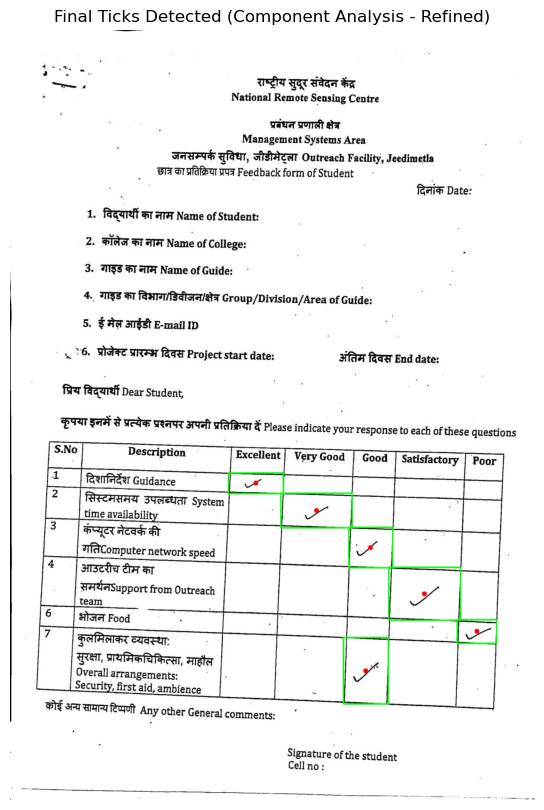

In [29]:
# Assuming 'cells_data' is populated correctly
# Assuming 'original_image' is your full BGR image for visualization
# Assuming 'display_image' function exists or you use cv2.imshow directly

ticked_cells_final = []
tick_columns_indices = [2, 3, 4, 5, 6]

original_image_column_headers = {
    "S.No": 0, "Description": 1, "Excellent": 2, "Very Good": 3,
    "Good": 4, "Satisfactory": 5, "Poor": 6
}
idx_to_col_name_map = {v: k for k, v in original_image_column_headers.items()}

cell_padding_for_tick_detection = 2

# --- Parameters for connected components ---
# Let's try to be slightly more conservative with min_tick_area if 100 was too low for some true ticks,
# but ensure it's high enough to kill most noise.
# The key will be the count of valid components.
min_tick_area = 70        # TUNE: Start here, might need to go up if noise persists
max_tick_area_ratio = 0.1 # TUNE: Ticks are usually a small part of the cell.
# min_tick_area_ratio = 0.01 # TUNE: Ticks are usually a small part of the cell.
min_aspect_ratio = 0.5    # TUNE
max_aspect_ratio = 1.5    # TUNE (allowing for w/h or h/w via logic below)

quit_debug_view = False
# print(f"DEBUG: Using min_tick_area = {min_tick_area}")
for cell_info in cells_data:
    if quit_debug_view: break
    if cell_info['col'] not in tick_columns_indices: continue

    cell_img_roi = cell_info['image_roi']
    if cell_img_roi is None or cell_img_roi.size == 0: continue

    blurred_cell = cv2.GaussianBlur(cell_img_roi, (1,1), 0)
    otsu_thresh_val, binary_tick_cell = cv2.threshold(
        blurred_cell, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
    )

    h, w = binary_tick_cell.shape
    core_cell_binary = binary_tick_cell
    if h > 2 * cell_padding_for_tick_detection and w > 2 * cell_padding_for_tick_detection:
        core_cell_binary = binary_tick_cell[
            cell_padding_for_tick_detection : h - cell_padding_for_tick_detection,
            cell_padding_for_tick_detection : w - cell_padding_for_tick_detection,
        ]
    if core_cell_binary.size == 0: continue
        
    total_pixels_in_core = core_cell_binary.shape[0] * core_cell_binary.shape[1]
    if total_pixels_in_core == 0: continue

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(core_cell_binary, connectivity=8)
    
    # --- Corrected Logic for finding a single valid tick component ---
    count_of_candidate_tick_components = 0
    candidate_tick_component_area = 0 # Store area of the one candidate

    if num_labels > 1:
        for i in range(1, num_labels): # Iterate over all components in the cell
            comp_area = stats[i, cv2.CC_STAT_AREA]
            if comp_area < min_tick_area:
                continue
            
            if total_pixels_in_core > 0 and (comp_area / total_pixels_in_core > max_tick_area_ratio): # or comp_area / total_pixels_in_core < min_tick_area_ratio):
                continue
        
            comp_w = stats[i, cv2.CC_STAT_WIDTH]
            comp_h = stats[i, cv2.CC_STAT_HEIGHT]
            current_aspect_ratio = comp_w / float(comp_h) if comp_h > 0 else float('inf')
            
            is_aspect_ratio_ok = False
            if min_aspect_ratio <= current_aspect_ratio <= max_aspect_ratio:
                 is_aspect_ratio_ok = True
            elif comp_w > 0 and (min_aspect_ratio <= (comp_h / float(comp_w)) <= max_aspect_ratio) : # Check inverse
                 is_aspect_ratio_ok = True
            
            if not is_aspect_ratio_ok:
                continue

            # ... (inside the component loop for i) ...
            # ... after component passes area and aspect ratio checks ...
        
            # Calculate Solidity and Extent for THIS component (s_area, s_w, s_h)
            single_component_mask = np.zeros(core_cell_binary.shape, dtype=np.uint8)
            single_component_mask[labels == i] = 255 
            contours, _ = cv2.findContours(single_component_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            solidity = 0.0 # Default if no contour or hull area is zero
            extent = 0.0   # Default
        
            if contours:
                cnt = contours[0]
                hull = cv2.convexHull(cnt)
                hull_area = cv2.contourArea(hull)
                if hull_area > 0:
                    solidity = float(comp_area) / hull_area
                    
                bounding_box_area_from_stats = comp_w * comp_h # comp_w, comp_h are from stats[i, ...]
                if bounding_box_area_from_stats > 0:
                    extent = float(comp_area) / bounding_box_area_from_stats
        
            # --- DEBUG PRINT for tuning (uncomment for specific cells) ---
            # if (cell_info['row'] == cell_info['col'] - 1) or \
               # (cell_info['row'] == 6 and cell_info['col'] == 4) : # Example FP and TP
                # print(f"  R{cell_info['row']}C{cell_info['col']} Comp {i}: Area={comp_area}, Solidity={solidity:.3f}, Extent={extent:.3f}")
        
            # --- New Filter Conditions ---
            # These are INITIAL GUESSES - TUNE BASED ON YOUR DATA COLLECTION
            min_solidity_for_tick = 0.3 
            max_solidity_for_tick = 0.5
        
            min_extent_for_tick = 0.05  
            max_extent_for_tick = 0.2
        
            if not (min_solidity_for_tick <= solidity <= max_solidity_for_tick):
                continue 
        
            if not (min_extent_for_tick <= extent <= max_extent_for_tick):
                continue 
        
            # If it passes all these, THEN it's a candidate
            count_of_candidate_tick_components += 1
            candidate_tick_component_area = comp_area
            # ... rest of the logic for count_of_candidate_tick_components == 1 ...
            
    found_tick_component = False
    if count_of_candidate_tick_components == 1: # Cell is ticked if EXACTLY ONE candidate component found
        found_tick_component = True
        tick_component_area = candidate_tick_component_area # Use the stored area
    # --- End of Corrected Logic ---

    if found_tick_component:
        col_idx = cell_info['col']
        col_name = idx_to_col_name_map.get(col_idx, f"Unknown Col ({col_idx})")

        ticked_cells_final.append({
            "row": cell_info['row'],
            "col": col_idx,
            "col_name": col_name,
            "component_area": tick_component_area,
            "original_bbox": cell_info['bbox_in_original_image']
        })
        # display_image(core_cell_binary)
        # --- Debugging (Optional) ---
    #     print(f"TICK (Single Valid Component) R{cell_info['row']}C{col_idx}, Area: {tick_component_area}, Otsu: {otsu_thresh_val}")
    #     cv2.imshow(f"TICK Cell R{cell_info['row']}C{col_idx} - Core Binary", core_cell_binary)
    #     key = cv2.waitKey(0) & 0xFF
    #     if key == ord('q'): quit_debug_view = True; break
    # else: # Debugging for cells NOT flagged
    #     if cell_info['col'] in tick_columns_indices: # Only show for relevant columns
    #         is_actually_ticked_in_image = True # Manually check the original image for this cell
    #         if is_actually_ticked_in_image: # False Negative
    #             print(f"FN: R{cell_info['row']}C{cell_info['col']}, ValidCand: {count_of_candidate_tick_components}, Otsu: {otsu_thresh_val}")
    #             cv2.imshow(f"FN Cell R{cell_info['row']}C{cell_info['col']} - Core Binary", core_cell_binary)
    #             key = cv2.waitKey(0) & 0xFF
    #             if key == ord('q'): quit_debug_view = True; break
    #         elif count_of_candidate_tick_components > 0 : # False Positive if this block were inside found_tick_component=False
    #             print(f"FP (but filtered by count): R{cell_info['row']}C{cell_info['col']}, ValidCand: {count_of_candidate_tick_components}, Otsu: {otsu_thresh_val}")
    #             cv2.imshow(f"FP(filtered) R{cell_info['row']}C{cell_info['col']} - Core Binary", core_cell_binary)
    #             key = cv2.waitKey(0) & 0xFF
    #             if key == ord('q'): quit_debug_view = True; break


if not quit_debug_view: cv2.destroyAllWindows()

print("\n--- Detected Ticked Cells (Component Analysis - Refined) ---")
original_image_with_ticks_viz = original_image.copy()
for ticked_info in ticked_cells_final:
    # print(f"TICK in Row: {ticked_info['row']}, Col: {ticked_info['col']} (Header: {ticked_info['col_name']}), Component Area: {ticked_info['component_area']}")
    x,y,w,h = ticked_info['original_bbox']
    cv2.rectangle(original_image_with_ticks_viz, (x,y), (x+w,y+h), (0,255,0), 2)
    cv2.circle(original_image_with_ticks_viz, (x + w//2, y + h//2), 5, (0,0,255), -1)

display_image(original_image_with_ticks_viz, "Final Ticks Detected (Component Analysis - Refined)")
# cv2.imshow("Final Ticks Detected (Component Analysis - Refined)", original_image_with_ticks_viz)
# cv2.waitKey(0)
# cv2.destroyAllWindows()